# Model building and evaluation

This notebook explores different methods to approach logistic regression regression. Since the number of observations (images) could be less than the number of trainable features, some dimension reduction is in order.

1. Local Binary Patterns (feature extraction using sklearn)  
2. Column means
3. Row means
4. Drop resolution by interpolating, flatten

In the end, option 4 performed the best so that one is included as the final logistic regression model. For the most up to date results and plots see the  models notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [2]:
import os # work with system    
import cv2 # work with images
import numpy as np # arrays and numerical analysis  
import matplotlib.pyplot as plt # for data plots

import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation
from skimage import feature # local binary patterns
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random # for random sampling 

### set working directory in data folder
os.chdir("drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject")

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Thu Apr 27 04:17:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# estimated runtime: 45 seconds
counter = 0 # if desired to break loop

# labels and filenames should match since they are appended in order
filenames = []
labels = []

# test_ood = []
# labels_ood = []

# one image does not open properly
empty_img = "MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG"
# walk through all directories and files in current working directory
for root, dir, files in os.walk(os.getcwd()):
    
    for jpg in files:
        if empty_img in os.path.join(root, jpg):
          print(empty_img)
          continue

        # if jpg file, then keep filename
        if ".JPG" in jpg:
            filenames.append(os.path.join(root, jpg))

        if "Empty" in root:
          labels.append(0)
        elif "Snake_Images" in root:
          labels.append(1)
            
    counter += 1
    # if counter > 10000: break

filenames_arr = np.array(filenames)
labels_arr = np.array(labels)
  
print(len(filenames))
# print(len(test_ood))

MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG
23275


In [6]:
def resample_classes(files, labels, seed = 1):

  '''
  files and labels should both be np arrays
  '''

  # set seed for reproducibility (and possibly error computation)
  random.seed(seed)
  # get number of minority class (snakes)
  n_minority = np.where(labels == 1)[0].shape[0]

  # sample from indices corresponding to empty images
  # downsample_idx should have as many indices as there are snake images
  downsample_idx = np.array(random.sample(list(np.where(labels == 0)[0]), n_minority))
  # final indices should have snakes and downsampled empties
  out_index = np.concatenate((np.where(labels == 1)[0], downsample_idx))

  # subset to resampled data - classes now balanced
  filenames_resampled = files[out_index]
  labels_resampled = labels[out_index]

  print(f'total samples: {out_index.shape[0]}')
  print(f'empty samples: {downsample_idx.shape[0]}')
  print(f'snake samples: {n_minority}')

  return filenames_resampled, labels_resampled

In [7]:
def split_data(files, labels, seed = 27, train = 0.8, test = 0.15):

  '''
  files and labels should both be np arrays
  '''

  # split data: train is 1-test_size and test is test_size*leftover
  # must stratify to ensure roughly equal splits in train, val, test
  # train and test specified, val is 1 - (train + test)
  x_train, x_test, y_train, y_test = train_test_split(
      files, labels, test_size = 1-train, stratify = labels, shuffle = True, random_state = seed)
  x_val, x_test, y_val, y_test = train_test_split(
      x_test, y_test, test_size = test/(1-train), stratify = y_test, shuffle = True, random_state = seed)
  
  print(f'train: {x_train.shape[0]} ({x_train.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'val: {x_val.shape[0]} ({x_val.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'test: {x_test.shape[0]} ({x_test.shape[0]/labels.shape[0]*100:.2f}%)')

  return x_train, y_train, x_val, y_val, x_test, y_test

In [8]:
def count_split(data): # much better would be to count 0 and 1 in y_* 

  data = list(data)
  snake = [x for x in data if "Snake_Images" in x]
  empty = [x for x in data if "Empty" in x]

  print(f'total: {len(data)}')
  print(f'snake: {len(snake)} ({len(snake)/len(data)*100:.2f}%)')
  print(f'empty: {len(empty)} ({len(empty)/len(data)*100:.2f}%)')

## Local Binary Patterns

This section explores the use of local binary patterns (texture) as a feature to feed into the logistic regression. Results are very poor - all images are predicted positive.

In [9]:
# import the necessary packages
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(lbp.ravel(),
			bins=np.arange(0, self.numPoints + 3),
			range=(0, self.numPoints + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

In [ ]:
class data_generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size, lbs) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.lbs = lbs
    print(self.image_filenames[0])
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    # read in as grayscale, resize to standard aspect ratio
    x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (512, 384), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]

    # convert to array, scale, and reshape for model
    if self.lbs:
      desc = LocalBinaryPatterns(24, 8)
      x_list = [desc.describe(image) for image in x_list]
      x_arr = np.array(x_list)
      x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], 1])
    else:
      x_arr = np.array(x_list)
      x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])
    
    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, lbs = False):

  train_generator = data_generator(x_train, y_train, batch_size, lbs)
  validation_generator = data_generator(x_val, y_val, batch_size, lbs)
  test_generator = data_generator(x_test, y_test, batch_size, lbs)  

  return train_generator, validation_generator, test_generator

In [ ]:
seed = 1
batch_size = 32

filenames_resampled, labels_resampled = resample_classes(filenames_arr, labels_arr, seed = seed)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(filenames_resampled, labels_resampled, train = 0.8, test = 0.15)

print()
count_split(x_train)
count_split(x_val)
count_split(x_test)
print()

train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, lbs = True)

total samples: 8406
empty samples: 4203
snake samples: 4203
train: 6724 (79.99%)
train: 420 (5.00%)
train: 1262 (15.01%)

total: 6724
snake: 3362 (50.00%)
empty: 3362 (50.00%)
total: 420
snake: 210 (50.00%)
empty: 210 (50.00%)
total: 1262
snake: 631 (50.00%)
empty: 631 (50.00%)

/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF13/IMG_1756.JPG
/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/FL_empty/WF9/IMG_5731.JPG
/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/SSF7/IMG_2918.JPG


In [ ]:
def build_log():

  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(26, 1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = "sigmoid"))

  # compile model with desired features
  model.compile(
    optimizer = "adam", loss = "binary_crossentropy",
    metrics=['accuracy']
  )

  return model

In [ ]:
# build the model
log_model = build_log()

In [ ]:
# see model structure
log_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 26)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 27        
                                                                 
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_fit = log_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    epochs = 3, # can change
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
)

Epoch 1/3
210/210 [==============================] - 9493s 45s/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/3
210/210 [==============================] - 781s 4s/step - loss: 0.6933 - accuracy: 0.4957 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/3
140/210 [===================>..........] - ETA: 4:03 - loss: 0.6933 - accuracy: 0.4884

In [ ]:
log_predict = log_model.predict(
    test_generator,
)

40/40 [==============================] - 1458s 37s/step


In [ ]:
# get class predictions
predictions_log = log_predict > 0.5
predictions_log = predictions_log.reshape(x_test.shape[0])
print(predictions_log.shape)

(1262,)


In [ ]:
set(list(predictions_log.reshape(1262)))

{True}

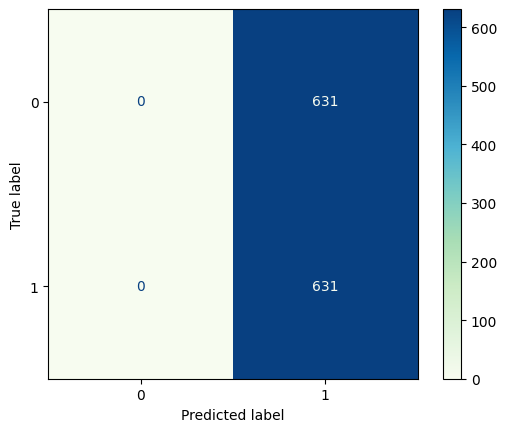

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_log, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_log)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_log)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_log)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_log, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%

0.5
0.5
1.0
0.0
0.6666666666666666


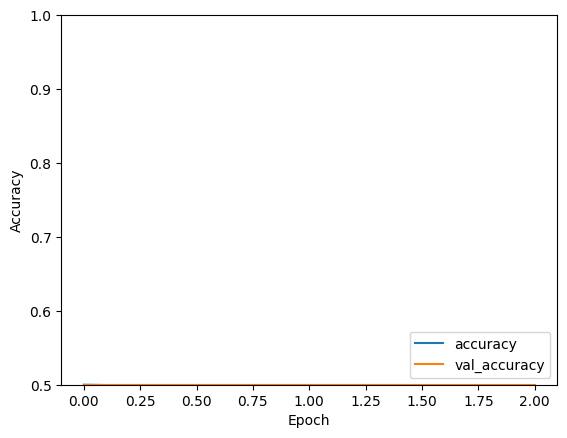

In [ ]:
# plot accuracy across epochs
plt.plot(log_fit.history['accuracy'], label='accuracy')
plt.plot(log_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
# plt.title("CNN model accuracy by epoch")
plt.legend(loc='lower right')


## Column means

This is a simple reduction that takes the mean pixel value across columns. In effect, this is no better than pixel change as when a snake is present the mean value will shift. However importantly, there will only be 513 trainable parameters, which is less than the number of observations in the training set.

In [ ]:
class data_generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size, log_mean) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.log_mean = log_mean
    print(self.image_filenames[0])
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    # read in as grayscale, resize to standard aspect ratio
    x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (512, 384), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]

    # convert to array, scale, and reshape for model
    if self.log_mean:
      x_arr = np.array(x_list)
      x_arr = np.mean(x_arr, 1) # take column mean (second dimension because first is the image index)
      x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], 1])
    else:
      x_arr = np.array(x_list)
      x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])
    
    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, log_mean = False):

  train_generator = data_generator(x_train, y_train, batch_size, log_mean)
  validation_generator = data_generator(x_val, y_val, batch_size, log_mean)
  test_generator = data_generator(x_test, y_test, batch_size, log_mean)  

  return train_generator, validation_generator, test_generator

In [ ]:
seed = 1
batch_size = 32

filenames_resampled, labels_resampled = resample_classes(filenames_arr, labels_arr, seed = seed)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(filenames_resampled, labels_resampled, train = 0.8, test = 0.15)

print()
count_split(x_train)
count_split(x_val)
count_split(x_test)
print()

train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, log_mean = True)

total samples: 8406
empty samples: 4203
snake samples: 4203
train: 6724 (79.99%)
train: 420 (5.00%)
train: 1262 (15.01%)

total: 6724
snake: 3362 (50.00%)
empty: 3362 (50.00%)
total: 420
snake: 210 (50.00%)
empty: 210 (50.00%)
total: 1262
snake: 631 (50.00%)
empty: 631 (50.00%)

/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF13/IMG_1756.JPG
/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/FL_empty/WF9/IMG_5731.JPG
/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/SSF7/IMG_2918.JPG


In [ ]:
def build_log():

  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(512, 1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = "sigmoid"))

  # compile model with desired features
  model.compile(
    optimizer = "adam", loss = "binary_crossentropy",
    metrics=['accuracy']
  )

  return model

In [ ]:
# build the model
log_model = build_log()

In [ ]:
# see model structure
log_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_fit = log_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    epochs = 3, # can change
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
)

Epoch 1/3
210/210 [==============================] - 195s 920ms/step - loss: 5.0069 - accuracy: 0.4898 - val_loss: 4.5167 - val_accuracy: 0.4808
Epoch 2/3
210/210 [==============================] - 182s 866ms/step - loss: 3.2395 - accuracy: 0.4981 - val_loss: 2.2374 - val_accuracy: 0.5120
Epoch 3/3
210/210 [==============================] - 181s 864ms/step - loss: 3.5095 - accuracy: 0.4976 - val_loss: 2.0213 - val_accuracy: 0.5385


In [ ]:
log_predict = log_model.predict(
    test_generator,
)

40/40 [==============================] - 34s 838ms/step


In [ ]:
# get class predictions
predictions_log = log_predict > 0.5
predictions_log = predictions_log.reshape(x_test.shape[0])
print(predictions_log.shape)

(1262,)


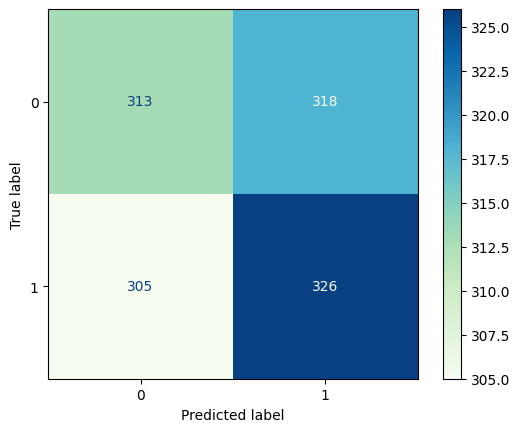

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_log, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_log)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_log)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_log)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_log, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%

0.506339144215531
0.5062111801242236
0.5166402535657686
0.4960380348652932
0.5113725490196079


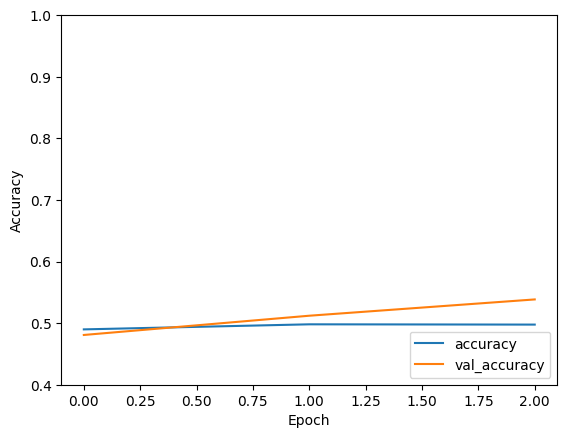

In [ ]:
# plot accuracy across epochs
plt.plot(log_fit.history['accuracy'], label='accuracy')
plt.plot(log_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
# plt.title("CNN model accuracy by epoch")
plt.legend(loc='lower right')

## Row means

This essentially like column means but on rows.

In [ ]:
class data_generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size, log_mean) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.log_mean = log_mean
    print(self.image_filenames[0])
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    # read in as grayscale, resize to standard aspect ratio
    x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (512, 384), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]

    # convert to array, scale, and reshape for model
    if self.log_mean:
      x_arr = np.array(x_list)
      x_arr = np.mean(x_arr, 2) # take column mean (second dimension because first is the image index)
      x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], 1])
    else:
      x_arr = np.array(x_list)
      x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])
    
    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, log_mean = False):

  train_generator = data_generator(x_train, y_train, batch_size, log_mean)
  validation_generator = data_generator(x_val, y_val, batch_size, log_mean)
  test_generator = data_generator(x_test, y_test, batch_size, log_mean)  

  return train_generator, validation_generator, test_generator

In [ ]:
seed = 1
batch_size = 32

filenames_resampled, labels_resampled = resample_classes(filenames_arr, labels_arr, seed = seed)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(filenames_resampled, labels_resampled, train = 0.8, test = 0.15)

print()
count_split(x_train)
count_split(x_val)
count_split(x_test)
print()

train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, log_mean = True)

total samples: 8406
empty samples: 4203
snake samples: 4203
train: 6724 (79.99%)
train: 420 (5.00%)
train: 1262 (15.01%)

total: 6724
snake: 3362 (50.00%)
empty: 3362 (50.00%)
total: 420
snake: 210 (50.00%)
empty: 210 (50.00%)
total: 1262
snake: 631 (50.00%)
empty: 631 (50.00%)

/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF13/IMG_1756.JPG
/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/FL_empty/WF9/IMG_5731.JPG
/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/SSF7/IMG_2918.JPG


In [ ]:
def build_log():

  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(384, 1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = "sigmoid"))

  # compile model with desired features
  model.compile(
    optimizer = "adam", loss = "binary_crossentropy",
    metrics=['accuracy']
  )

  return model

In [ ]:
# build the model
log_model = build_log()

In [ ]:
# see model structure
log_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 384)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 385       
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_fit = log_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    epochs = 3, # can change
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
)

Epoch 1/3
210/210 [==============================] - 194s 914ms/step - loss: 3.8121 - accuracy: 0.5200 - val_loss: 2.5354 - val_accuracy: 0.5938
Epoch 2/3
210/210 [==============================] - 190s 906ms/step - loss: 2.2599 - accuracy: 0.5514 - val_loss: 1.5611 - val_accuracy: 0.5385
Epoch 3/3
210/210 [==============================] - 174s 830ms/step - loss: 2.2755 - accuracy: 0.5432 - val_loss: 1.3728 - val_accuracy: 0.5697


In [ ]:
log_predict = log_model.predict(
    test_generator,
)

40/40 [==============================] - 30s 761ms/step


In [ ]:
# get class predictions
predictions_log = log_predict > 0.5
predictions_log = predictions_log.reshape(x_test.shape[0])
print(predictions_log.shape)

(1262,)


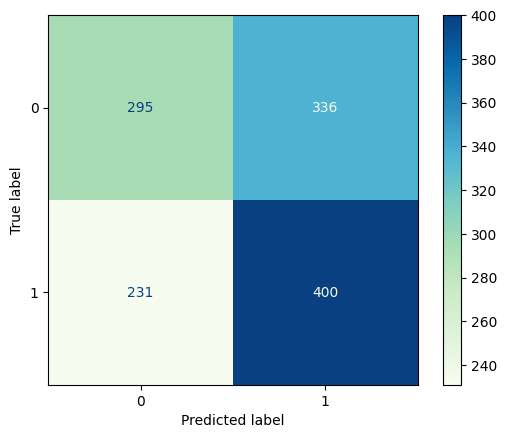

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_log, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_log)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_log)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_log)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_log, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%

0.5507131537242472
0.5434782608695652
0.6339144215530903
0.4675118858954041
0.5852231163130943


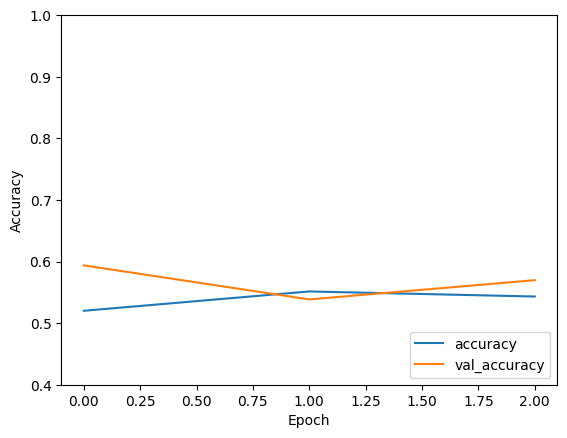

In [ ]:
# plot accuracy across epochs
plt.plot(log_fit.history['accuracy'], label='accuracy')
plt.plot(log_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
# plt.title("CNN model accuracy by epoch")
plt.legend(loc='lower right')

## Resolution drop

Drop the resolution precipitously to get # features < observations

Note we have just over 6700 images in the train set, so I have dropped the resolution to 100x60 which  will give 6001 trainable parameters - less than the number of observations. This is also less than the 6452 images in the training data when holding one camera out (see mdels_od_1cam).



In [ ]:
class data_generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size, log_mean) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.log_mean = log_mean
    print(self.image_filenames[0])
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    # read in as grayscale, resize to standard aspect ratio
    x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (100, 67), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]

    # convert to array, scale, and reshape for model
    if self.log_mean:
      x_arr = np.array(x_list)
      x_arr = np.mean(x_arr, 1) # take column mean (second dimension because first is the image index)
      x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], 1])
    else:
      x_arr = np.array(x_list)
      x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])
    
    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, log_mean = False):

  train_generator = data_generator(x_train, y_train, batch_size, log_mean)
  validation_generator = data_generator(x_val, y_val, batch_size, log_mean)
  test_generator = data_generator(x_test, y_test, batch_size, log_mean)  

  return train_generator, validation_generator, test_generator

In [ ]:
seed = 1
batch_size = 32

filenames_resampled, labels_resampled = resample_classes(filenames_arr, labels_arr, seed = seed)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(filenames_resampled, labels_resampled, train = 0.8, test = 0.15)

print()
count_split(x_train)
count_split(x_val)
count_split(x_test)
print()

train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, log_mean = False)

total samples: 8406
empty samples: 4203
snake samples: 4203
train: 6724 (79.99%)
train: 420 (5.00%)
train: 1262 (15.01%)

total: 6724
snake: 3362 (50.00%)
empty: 3362 (50.00%)
total: 420
snake: 210 (50.00%)
empty: 210 (50.00%)
total: 1262
snake: 631 (50.00%)
empty: 631 (50.00%)

/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF13/IMG_1756.JPG
/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/FL_empty/WF9/IMG_5731.JPG
/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/SSF7/IMG_2918.JPG


In [ ]:
def build_log():

  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(60, 100, 1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = "sigmoid"))

  # compile model with desired features
  model.compile(
    optimizer = "adam", loss = "binary_crossentropy",
    metrics=['accuracy']
  )

  return model

In [ ]:
# build the model
log_model = build_log()

In [ ]:
# see model structure
log_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 6700)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 6701      
                                                                 
Total params: 6,701
Trainable params: 6,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_fit = log_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    epochs = 3, # can change
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
)

Epoch 1/3
210/210 [==============================] - 183s 864ms/step - loss: 19.0351 - accuracy: 0.6478 - val_loss: 4.8676 - val_accuracy: 0.7981
Epoch 2/3
210/210 [==============================] - 179s 855ms/step - loss: 7.3548 - accuracy: 0.7833 - val_loss: 3.2416 - val_accuracy: 0.8702
Epoch 3/3
210/210 [==============================] - 183s 869ms/step - loss: 5.4993 - accuracy: 0.8488 - val_loss: 4.8972 - val_accuracy: 0.8365


In [ ]:
log_predict = log_model.predict(
    test_generator,
)

40/40 [==============================] - 33s 820ms/step


In [ ]:
# get class predictions
predictions_log = log_predict > 0.5
predictions_log = predictions_log.reshape(x_test.shape[0])
print(predictions_log.shape)

(1262,)


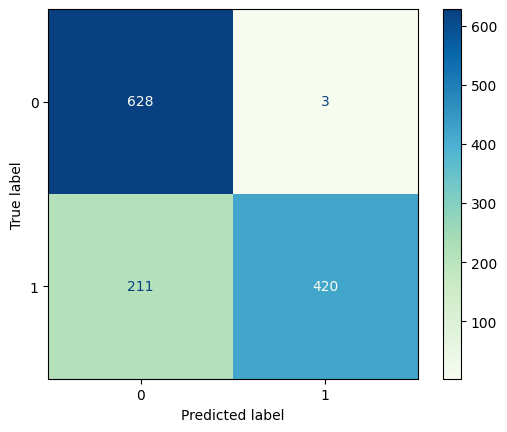

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_log, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print("accuracy: " + str(accuracy))

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print("precision: " + str(precision))

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print("sensitivity: " + str(sensitivity))

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print("specificity: " + str(specificity))

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print("f1_score: " + str(f1_score))

# no false positives means precision and specificity will be 100%

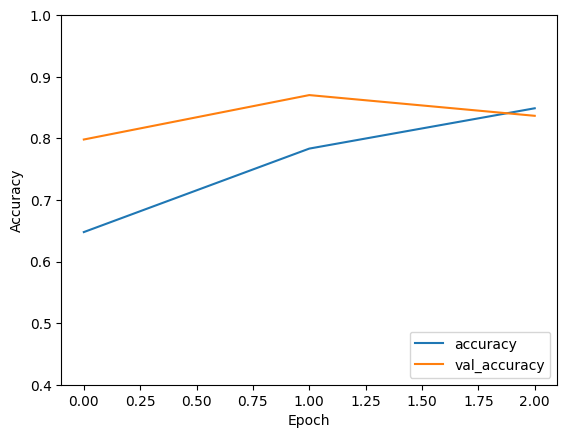

In [ ]:
# plot accuracy across epochs
plt.plot(log_fit.history['accuracy'], label='accuracy')
plt.plot(log_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
# plt.title("CNN model accuracy by epoch")
plt.legend(loc='lower right')